In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sn
from IPython.display import display
from astropy.coordinates import SkyCoord
import astropy.units as u
from functools import reduce
import re
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import lmfit
from lmfit import Model
from scipy.optimize import curve_fit
from astropy.visualization import simple_norm
import glob
import os

In [29]:
# Define column names based on the header in the SRL file
column_names = [
    "Source_id", "Isl_id", "RA", "E_RA", "DEC", "E_DEC", "Total_flux", "E_Total_flux",
    "Peak_flux", "E_Peak_flux", "RA_max", "E_RA_max", "DEC_max", "E_DEC_max", "Maj", 
    "E_Maj", "Min", "E_Min", "PA", "E_PA", "Maj_img_plane", "E_Maj_img_plane", 
    "Min_img_plane", "E_Min_img_plane", "PA_img_plane", "E_PA_img_plane", "DC_Maj", 
    "E_DC_Maj", "DC_Min", "E_DC_Min", "DC_PA", "E_DC_PA", "DC_Maj_img_plane", 
    "E_DC_Maj_img_plane", "DC_Min_img_plane", "E_DC_Min_img_plane", "DC_PA_img_plane", 
    "E_DC_PA_img_plane", "Isl_Total_flux", "E_Isl_Total_flux", "Isl_rms", "Isl_mean", 
    "Resid_Isl_rms", "Resid_Isl_mean", "S_Code"
]

In [30]:
# Define the path to the directory containing .srl files
path = '../paper1/epoch/32/*.srl'

# Use glob to get a list of all .srl files in the directory
files = glob.glob(path)

# Create a dictionary to store DataFrames
dataframes = {}

# Loop through each file and read it into a DataFrame
for file in files:
    # Extract the filename without the directory
    filename = os.path.basename(file)
#     print(f"Processing file: {file}")
    
    # Read the .srl file into a DataFrame
    # Adjust the method based on the file format
    df = pd.read_csv(file, delim_whitespace=True, comment='#', names=column_names)  # or another separator if needed
    
    # Save the DataFrame in the dictionary with the filename as the key
    dataframes[filename] = df
    
    # Define the output file path (adjust the output directory as needed)
    output_file = os.path.join('../paper1/epoch/32/processed', f"{os.path.splitext(filename)[0]}.csv")
    
    # Ensure the output directory exists
    os.makedirs(os.path.dirname(output_file), exist_ok=True)
    
    # Save the DataFrame to a CSV file
    df.to_csv(output_file, index=False)
    print(f"Saved DataFrame to: {output_file}")

Saved DataFrame to: ../paper1/epoch/32/processed/19B-053_2020_01_01_T03_24_58.228-2.5arcsec-nit5000-awproject.image.tt0.smo.pybdsf.csv
Saved DataFrame to: ../paper1/epoch/32/processed/19B-053_2020_01_01_T02_00_56.076-2.5arcsec-nit5000-awproject.image.tt0.smo.pybdsf.csv
Saved DataFrame to: ../paper1/epoch/32/processed/19B-053_2019_12_16_T08_12_56.775-2.5arcsec-nit5000-awproject.image.tt0.smo.pybdsf.csv
Saved DataFrame to: ../paper1/epoch/32/processed/19B-053_2019_12_28_T04_48_58.627-2.5arcsec-nit5000-awproject.image.tt0.smo.pybdsf.csv
Saved DataFrame to: ../paper1/epoch/32/processed/19B-053_2019_12_15_T07_36_56.546-2.5arcsec-nit5000-awproject.image.tt0.smo.pybdsf.csv
Saved DataFrame to: ../paper1/epoch/32/processed/19B-053_2020_01_03_T03_00_57.672-2.5arcsec-nit5000-awproject.image.tt0.smo.pybdsf.csv


In [64]:
import pandas as pd
import glob
import os

# Define the path to the directory containing the processed .csv files
path = '../paper1/epoch/32/processed/*.csv'

# Use glob to get a list of all .csv files in the directory
files = glob.glob(path)

# Create a dictionary to manually map filenames to their respective dates
file_to_date = {
    '19B-053_2019_12_16_T08_12_56.775-2.5arcsec-nit5000-awproject.image.tt0.smo.pybdsf.csv': '2019_12_16',
    '19B-053_2020_01_01_T03_24_58.228-2.5arcsec-nit5000-awproject.image.tt0.smo.pybdsf.csv': '2020_01_01',
    '19B-053_2020_01_01_T02_00_56.076-2.5arcsec-nit5000-awproject.image.tt0.smo.pybdsf.csv': '2020_01_01',
    '19B-053_2019_12_28_T04_48_58.627-2.5arcsec-nit5000-awproject.image.tt0.smo.pybdsf.csv': '2019_12_28',
    '19B-053_2019_12_15_T07_36_56.546-2.5arcsec-nit5000-awproject.image.tt0.smo.pybdsf.csv': '2019_12_15',
    '19B-053_2020_01_03_T03_00_57.672-2.5arcsec-nit5000-awproject.image.tt0.smo.pybdsf.csv': '2020_01_03'
}

# Create a list to store DataFrames along with their corresponding dates
dataframes = []

# Loop through each file and read it into a DataFrame, adding the 'Time' column
for file in files:
    filename = os.path.basename(file)
    if filename in file_to_date:
        df = pd.read_csv(file)
        # Add a new column 'Time' with the manually mapped date
        df['Times'] = file_to_date[filename]
        dataframes.append(df)
    else:
        print(f"Skipping file {filename} as it is not in the date mapping dictionary.")

# Function to check if two sources match within their error bounds
def sources_match(row1, row2):
    ra_match = abs(row1['RA'] - row2['RA']) <= (row1['E_RA'] + row2['E_RA'])
    dec_match = abs(row1['DEC'] - row2['DEC']) <= (row1['E_DEC'] + row2['E_DEC'])
    return ra_match and dec_match

# Find sources repeated in all DataFrames and collect their times
repeated_sources = []
first_df = dataframes[0]

for _, source in first_df.iterrows():
    source_repeated = True
    matched_rows = [source]
    
    for df in dataframes[1:]:
        match_found = False
        for _, candidate in df.iterrows():
            if sources_match(source, candidate):
                matched_rows.append(candidate)
                match_found = True
                break
        if not match_found:
            source_repeated = False
            break
    
    if source_repeated:
        combined_info = {}
        for row in matched_rows:
            for col in row.index:
                if col not in combined_info:
                    combined_info[col] = []
                combined_info[col].append(row[col])
        
        # Flatten the combined_info dictionary into a single row
        for key in combined_info:
            combined_info[key] = ', '.join(map(str, combined_info[key]))
        
        repeated_sources.append(combined_info)

# Convert the list of repeated sources to a DataFrame
repeated_sources_df = pd.DataFrame(repeated_sources)

# Save the DataFrame to a CSV file
repeated_sources_df.to_csv('../paper1/epoch/32/processed/repeated_sources_with_times.csv', index=False)

print(f"Repeated sources with times saved to: ../paper1/epoch/32/processed/repeated_sources_with_times.csv")


Skipping file repeated_sources_with_times.csv as it is not in the date mapping dictionary.
Skipping file repeated_sources.csv as it is not in the date mapping dictionary.
Skipping file repeated_sources_with_time.csv as it is not in the date mapping dictionary.
Repeated sources with times saved to: ../paper1/epoch/32/processed/repeated_sources_with_times.csv


In [65]:

# Define the path to the CSV file
csv_path = '../paper1/epoch/32/processed/repeated_sources_with_times.csv'

# Read the CSV file into a DataFrame
repeated_sources_df = pd.read_csv(csv_path)

# Display the first few rows of the DataFrame
print("Repeated sources DataFrame:")
repeated_sources_df


Repeated sources DataFrame:


,Source_id,Isl_id,RA,E_RA,DEC,E_DEC,Total_flux,E_Total_flux,Peak_flux,E_Peak_flux,...,DC_PA_img_plane,E_DC_PA_img_plane,Isl_Total_flux,E_Isl_Total_flux,Isl_rms,Isl_mean,Resid_Isl_rms,Resid_Isl_mean,S_Code,Times
0,"17, 18, 23, 17, 17, 20","16, 17, 21, 17, 15, 18","53.7980118419408, 53.79833519038475, 53.797524...","0.00064082408276, 0.00066209790054, 0.00058089...","31.33065131176003, 31.33045928907485, 31.33127...","0.00052546050612, 0.00079507351517, 0.00060058...","0.00456380546625, 0.00561905524753, 0.00392863...","0.00060590409995, 0.00093194723862, 0.00060642...","0.00472003056107, 0.00584200352428, 0.00476112...","0.00035700070726, 0.00055056960724, 0.00039704...",...,"0.0, 0.0, 0.0, 0.0, 32.14935613458065, 55.9875...","30.1018970498426, 32.06520155169263, 86.477188...","0.00395342993561, 0.00459803635819, 0.00320423...","0.00028369248456, 0.00044118391582, 0.00027814...","0.00036089093192, 0.00055782019626, 0.00041960...","-1.044342662e-05, -4.13577663e-06, -6.1178355e...","6.523700722e-05, 7.609622116e-05, 5.652035907e...","-9.71112786e-06, -3.45678086e-06, -1.57980924e...","S, S, S, S, S, S","2019_12_16, 2020_01_01, 2020_01_01, 2019_12_28..."
1,"26, 25, 31, 23, 23, 27","25, 24, 29, 23, 21, 25","53.69773026241979, 53.6972520436302, 53.697339...","0.00089087458086, 0.0006900716147, 0.000635814...","30.87395523149715, 30.87450660526302, 30.87426...","0.00066356499627, 0.00046010349721, 0.00049631...","0.0069472002746, 0.0068848600408, 0.0076486518...","0.0011835772061, 0.00082721122768, 0.000932321...","0.00688939906079, 0.00657292633211, 0.00742333...","0.00067702661709, 0.00045899380939, 0.00052604...",...,"0.0, 0.0, 0.0, 96.4234331531154, 0.0, 0.0","28.84361435192045, 13.74768693025426, 22.75684...","0.00569510032926, 0.00612668779003, 0.00666699...","0.00053225173217, 0.00041384623032, 0.00046843...","0.00067847990431, 0.00045863960986, 0.00052405...","-1.044342662e-05, -4.13577709e-06, -6.1178355e...","0.00019932141004, 0.00024909357307, 0.00018871...","-3.91382764e-06, 6.36987033e-06, 5.94593894e-0...","S, S, S, S, S, S","2019_12_16, 2020_01_01, 2020_01_01, 2019_12_28..."
2,"28, 27, 34, 26, 26, 29","27, 26, 32, 26, 24, 27","53.61793678470821, 53.61640363140359, 53.61751...","0.00107778968841, 0.00088376274196, 0.00105207...","30.58189342902934, 30.58175295664541, 30.58348...","0.00077016307021, 0.00072990260949, 0.00102400...","0.00368635232212, 0.00348166839267, 0.00462093...","0.00070963772275, 0.00063703465707, 0.00089768...","0.0034634833189, 0.00362736218505, 0.003760355...","0.00039086990927, 0.00037638234552, 0.00045039...",...,"0.0, 0.0, 51.01680843058465, 111.9256912959651...","27.2161942046966, 29.6710249195663, 73.5921299...","0.00274817504815, 0.00266568523315, 0.00363246...","0.00026566523326, 0.00026292786106, 0.00034029...","0.00038760181633, 0.00038206641329, 0.00043156...","-1.044342662e-05, -4.13577618e-06, -6.1178355e...","3.093299892e-05, 3.399991328e-05, 8.981380961e...","-1.087087185e-05, -5.08671019e-06, -9.0358458e...","S, S, S, S, S, S","2019_12_16, 2020_01_01, 2020_01_01, 2019_12_28..."
3,"34, 33, 41, 31, 32, 36","33, 32, 38, 31, 29, 33","53.56556028476285, 53.56540749499198, 53.56528...","0.00075271756585, 0.00099500851309, 0.00042076...","30.74798176244849, 30.7474031274975, 30.747677...","0.00081188096023, 0.001271630417, 0.0004809231...","0.00549407669381, 0.00623234951653, 0.00500194...","0.00087610958389, 0.00134740785973, 0.00050998...","0.00494625861048, 0.00520832658147, 0.00522222...","0.0004712155571, 0.00068739074812, 0.000301587...",...,"4.50455878623709, 6.1387423467099, 0.0, 0.0, 0...","100.39573393819558, 43.82372359406389, 15.8104...","0.00454113654517, 0.00466909380063, 0.00440179...","0.00036900537248, 0.00046674780129, 0.00025153...","0.00046008586651, 0.00066333351424, 0.00030646...","-1.044342662e-05, -4.13577618e-06, -6.1178355e...","7.968254067e-05, 4.785819692e-05, 5.154589962e...","-8.65600578e-06, -3.21616562e-06, -1.61161165e...","S, S, S, S, S, S","2019_12_16, 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


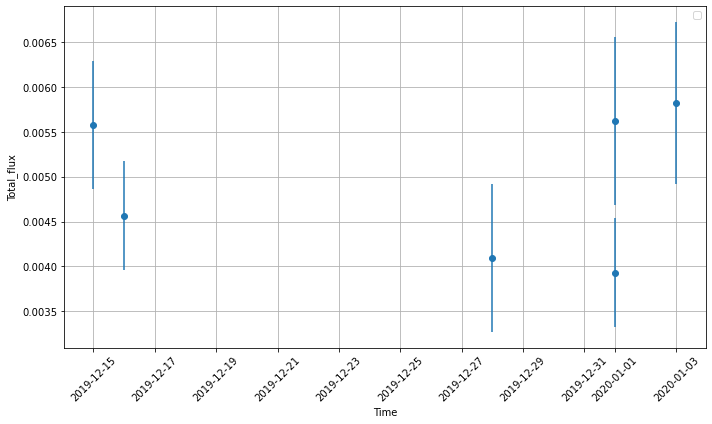

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


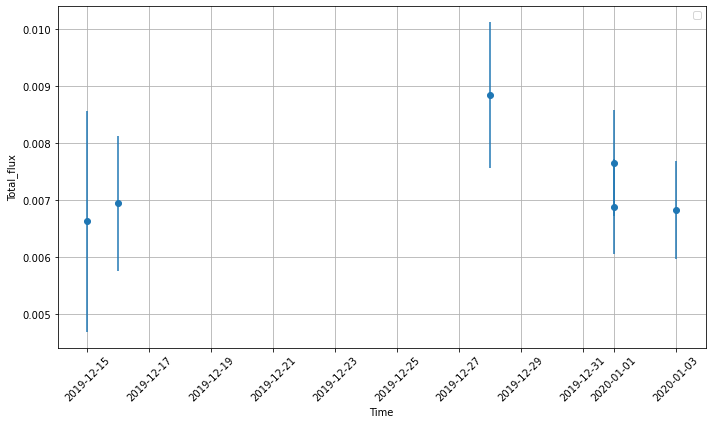

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


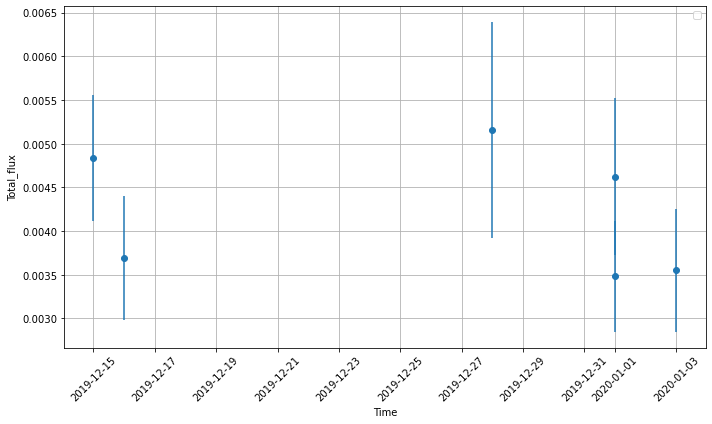

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


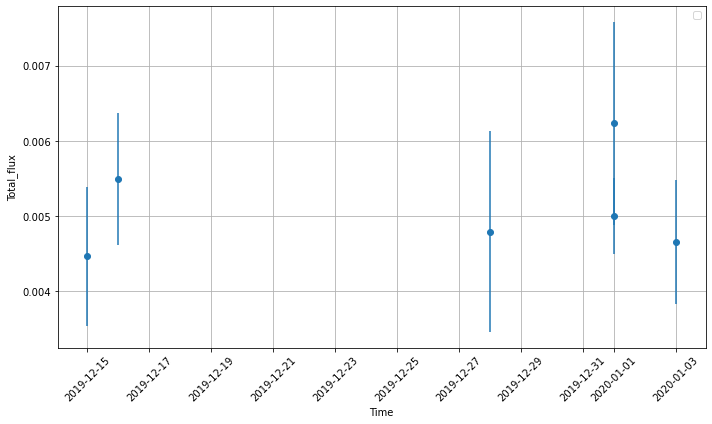

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


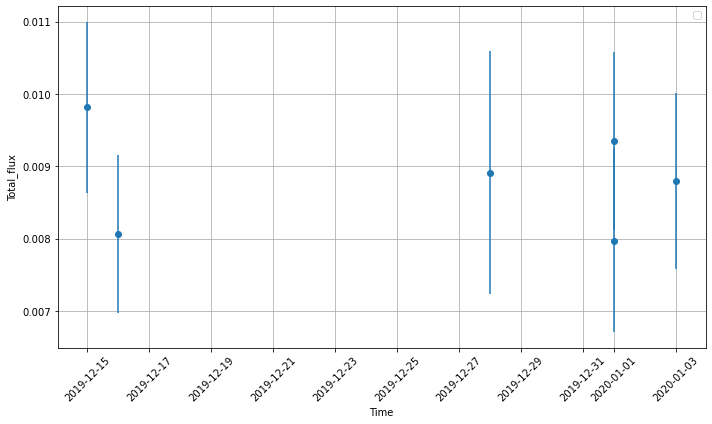

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


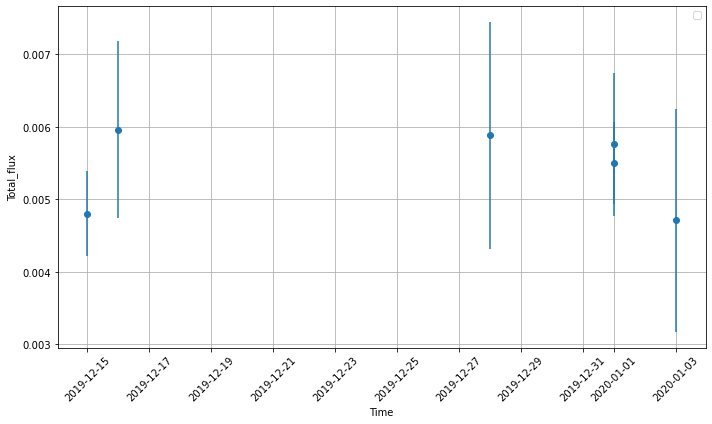

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


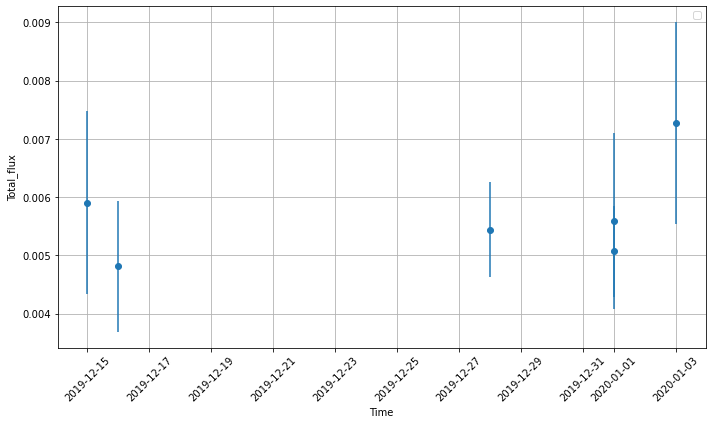

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


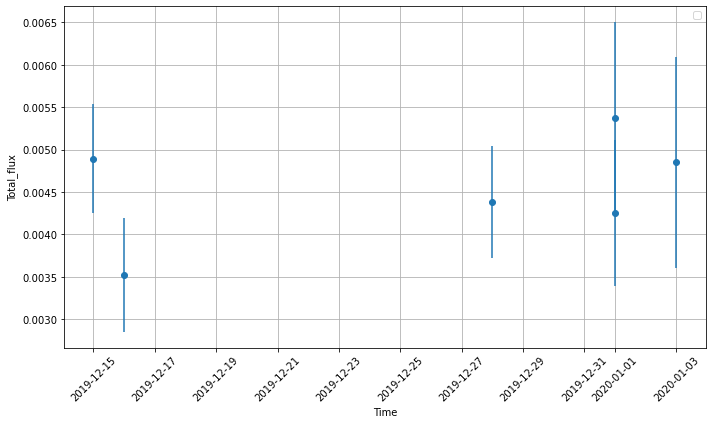

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


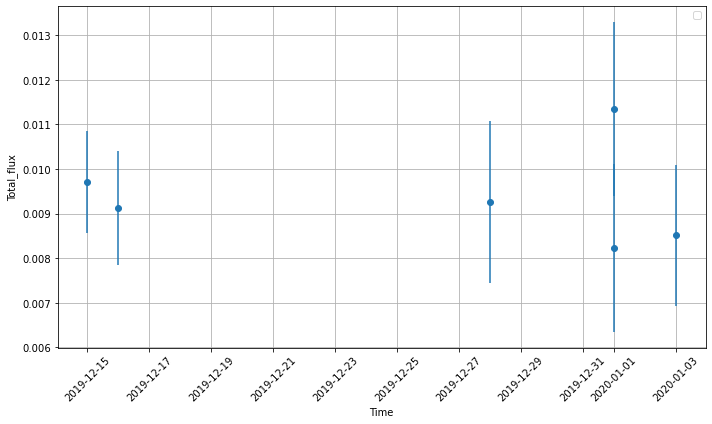

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


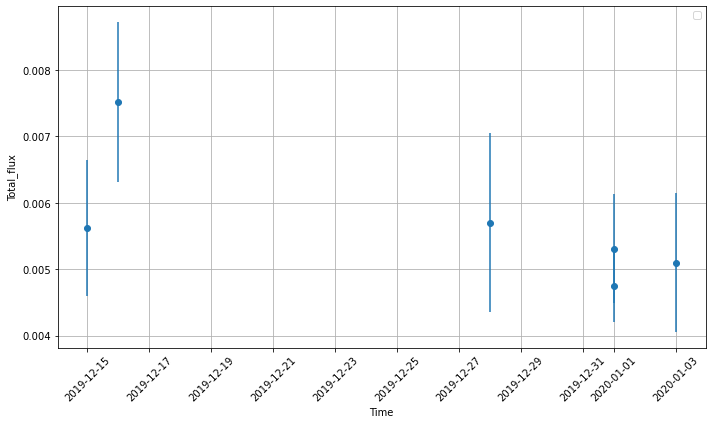

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


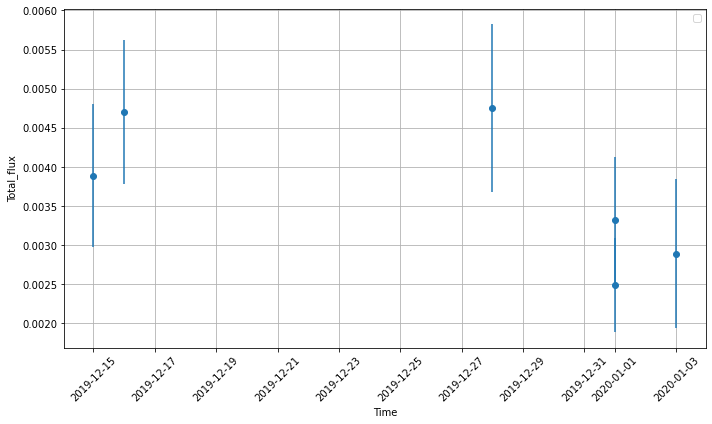

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


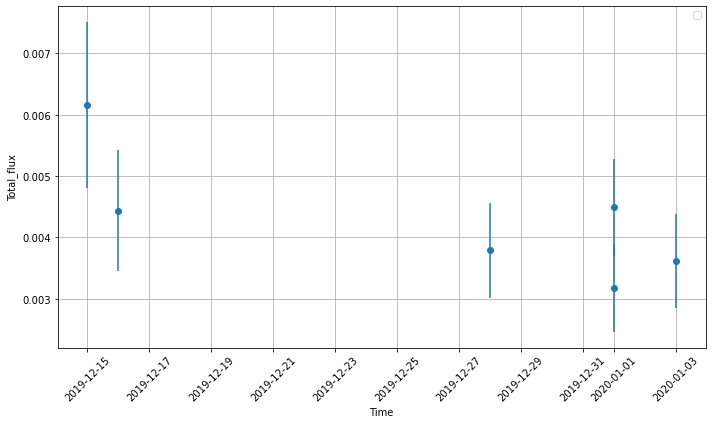

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


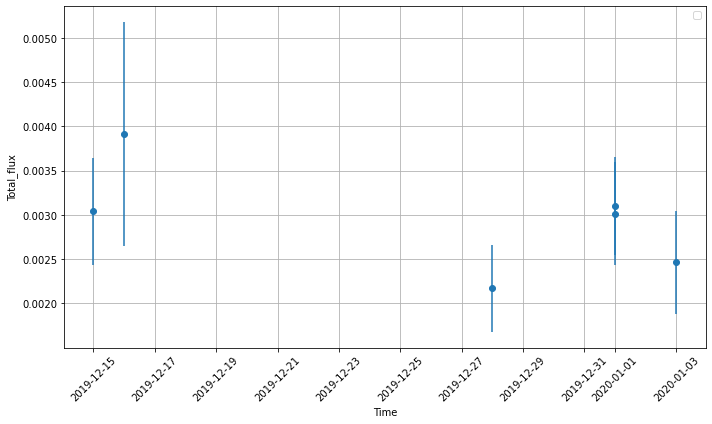

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


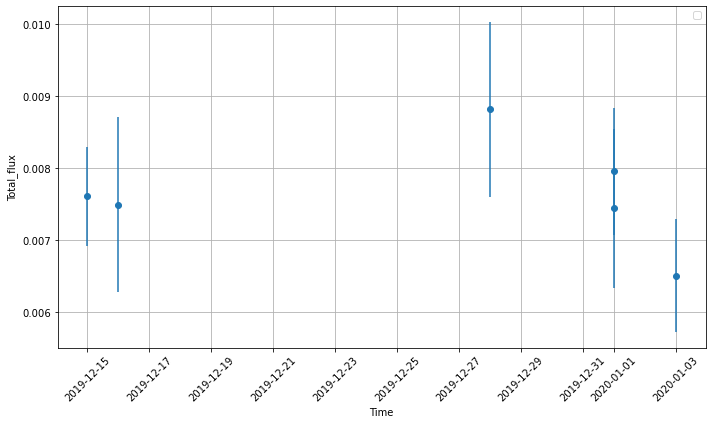

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


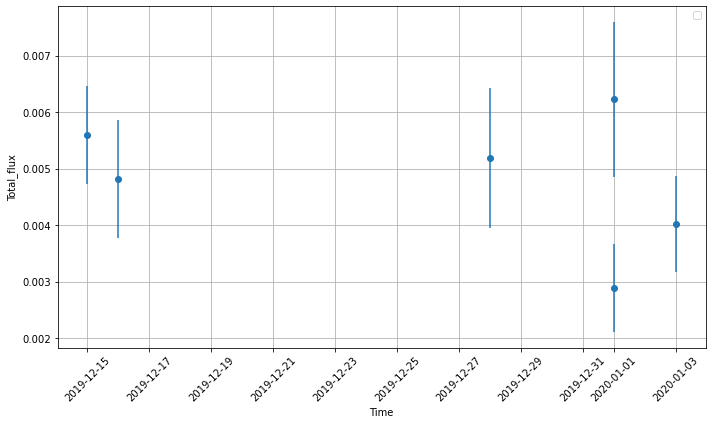

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


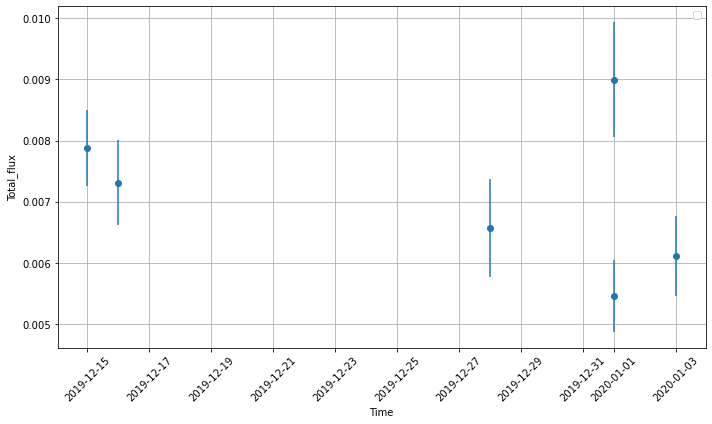

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


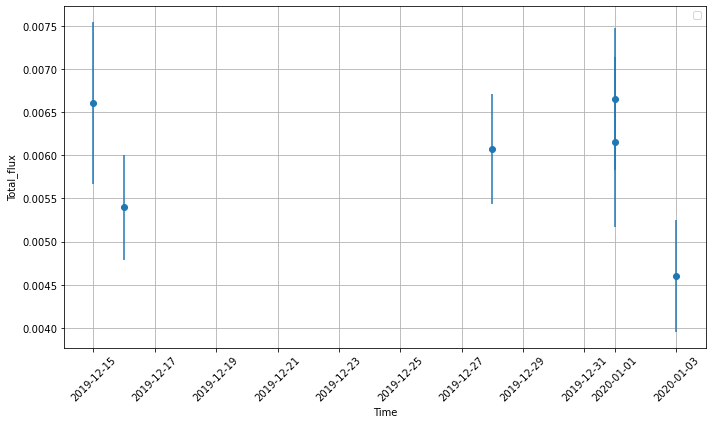

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


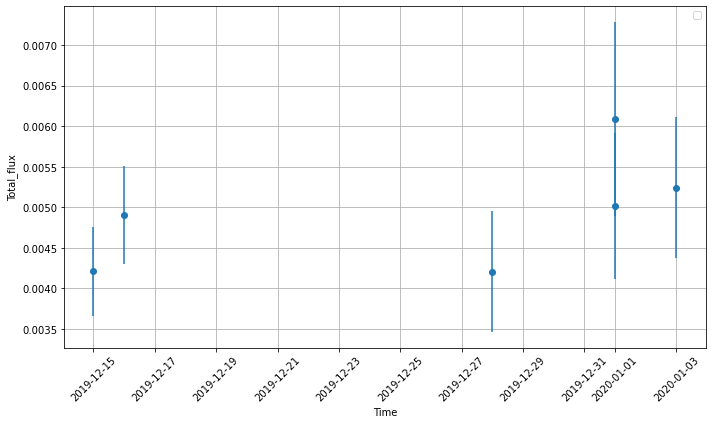

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


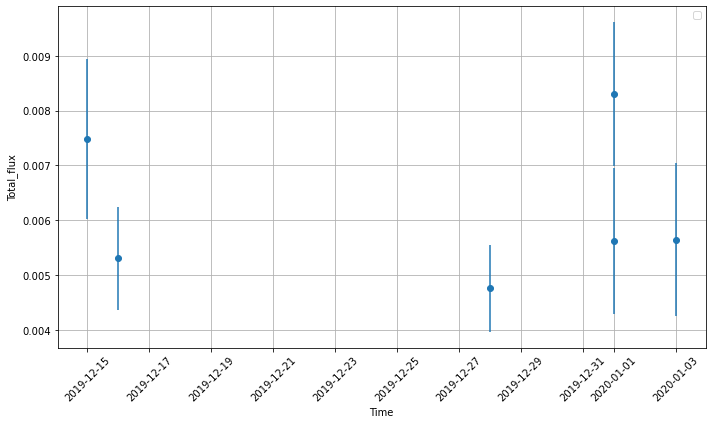

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


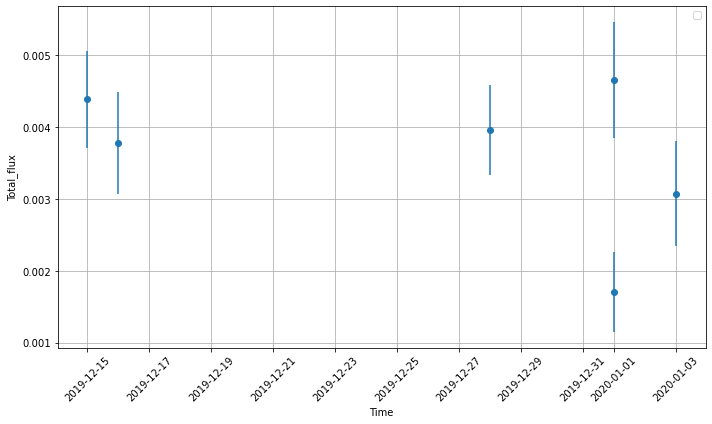

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


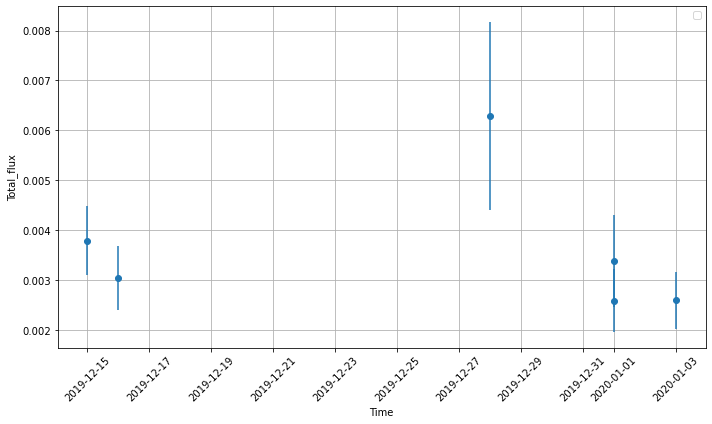

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


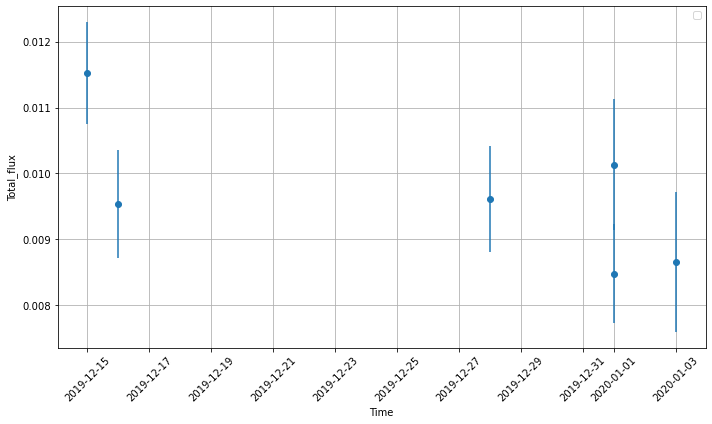

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


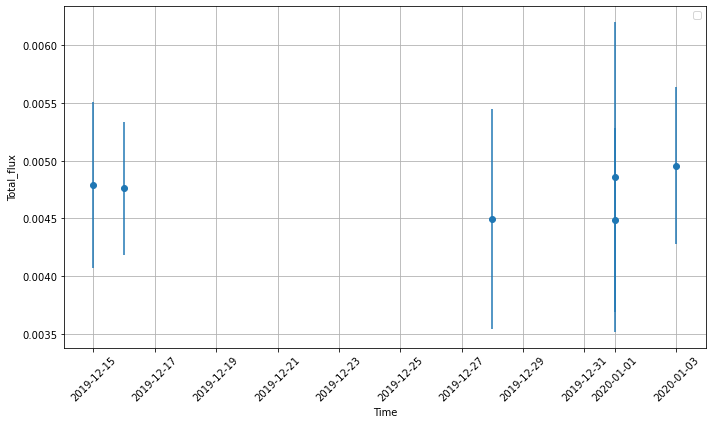

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


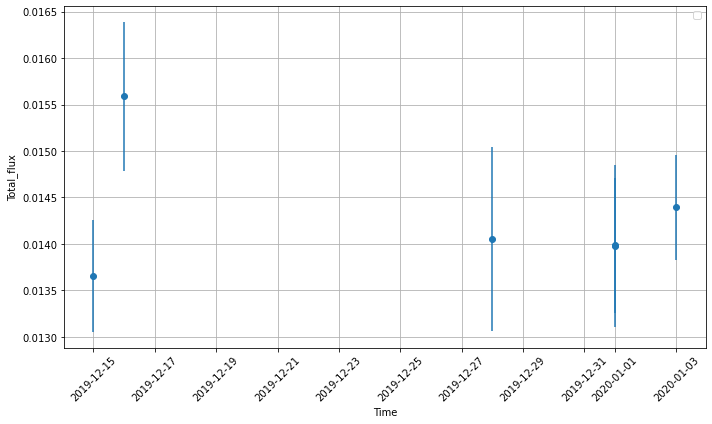

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


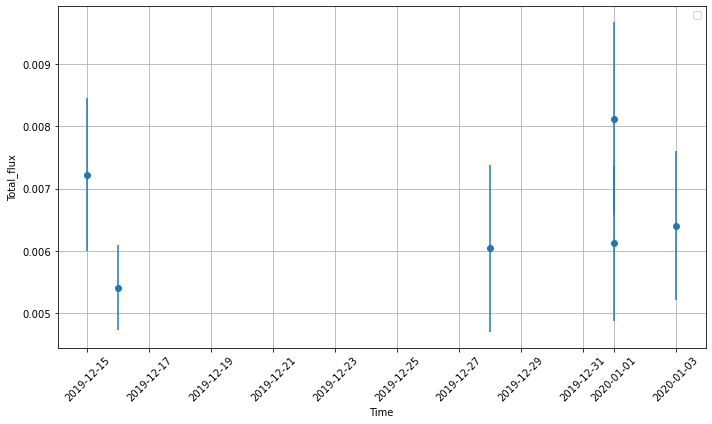

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


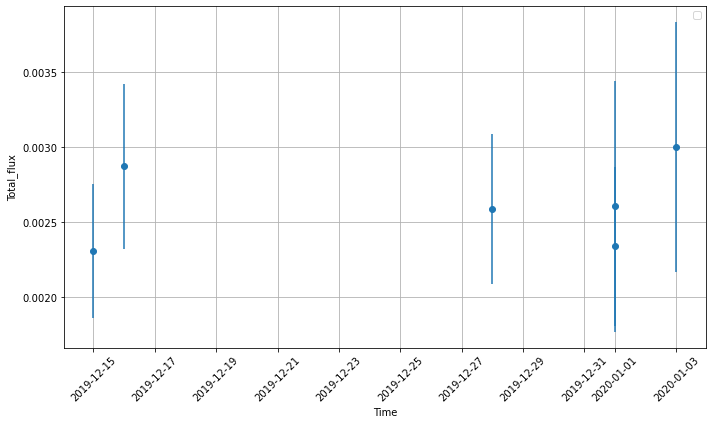

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


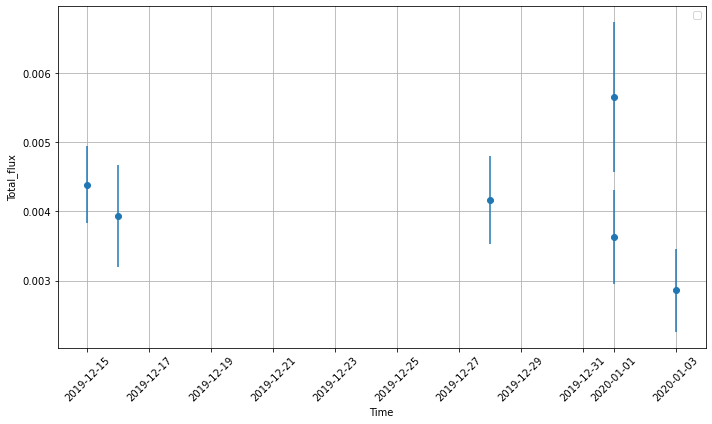

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


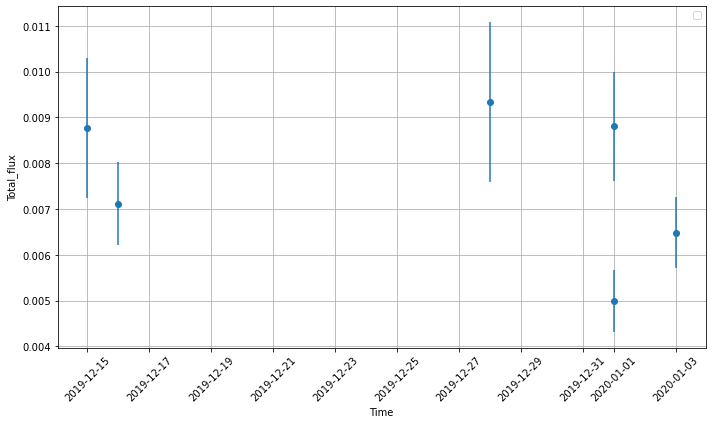

In [76]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the repeated sources file
file_path = '../paper1/epoch/32/processed/repeated_sources_with_times.csv'
df = pd.read_csv(file_path)

# Ensure 'Times', 'Total_flux', and 'E_Total_flux' are lists of values
df['Times'] = df['Times'].apply(lambda x: x.strip('[]').replace("'", "").split(', '))
df['Total_flux'] = df['Total_flux'].apply(lambda x: list(map(float, x.strip('[]').split(', '))))
df['E_Total_flux'] = df['E_Total_flux'].apply(lambda x: list(map(float, x.strip('[]').split(', '))))

# Plot 'Total_flux' with 'E_Total_flux' as error bars for each source over time
for index, source in df.iterrows():
    times = pd.to_datetime(source['Times'], format='%Y_%m_%d')
    total_flux = source['Total_flux']
    e_total_flux = source['E_Total_flux']
    
    plt.figure(figsize=(10, 6))  # Increase figure size
    plt.errorbar(times, total_flux, yerr=e_total_flux, fmt='o')
    plt.xlabel('Time')
    plt.ylabel('Total_flux')
#     plt.title(f'Total_flux over Time with Error Bars for Source RA: {source["RA"]}, DEC: {source["DEC"]}')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


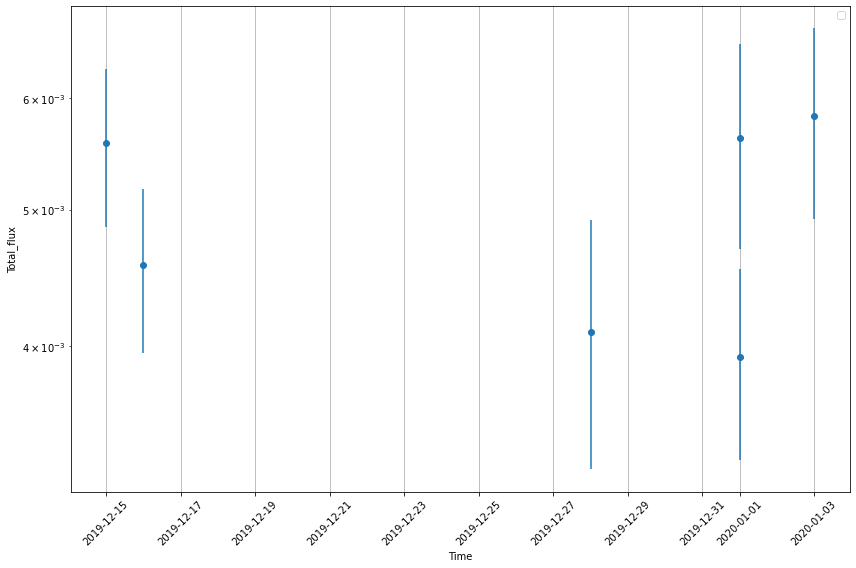

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


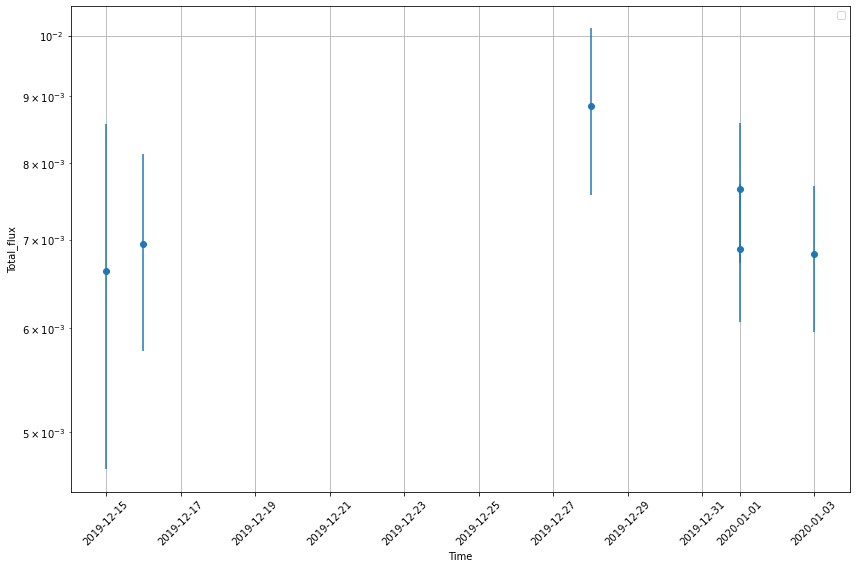

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


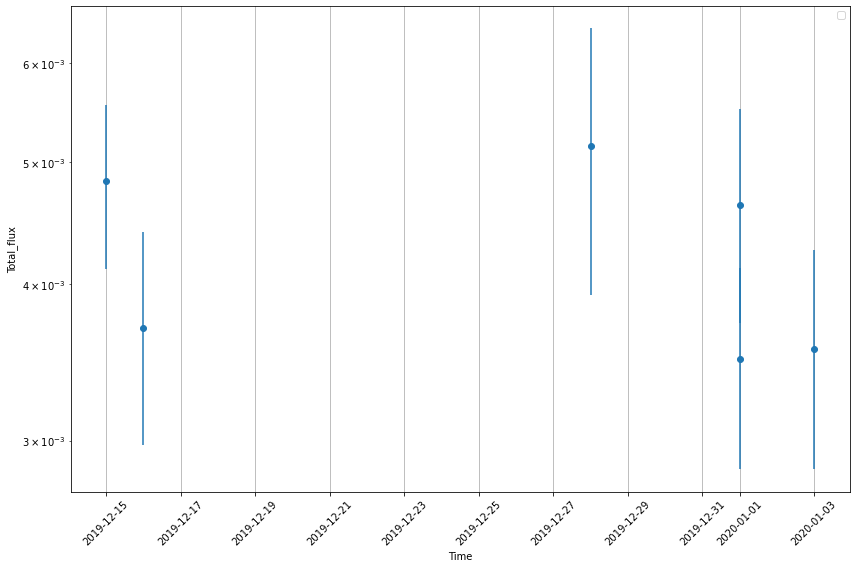

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


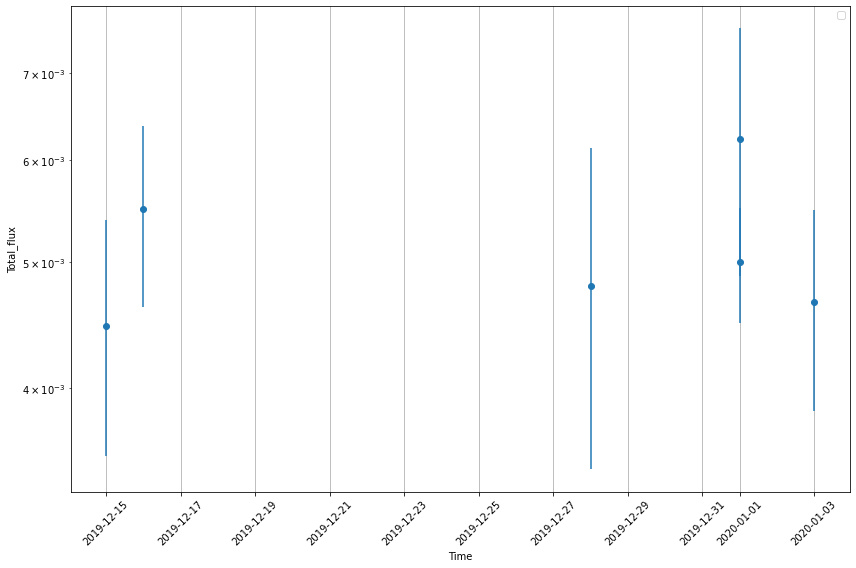

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


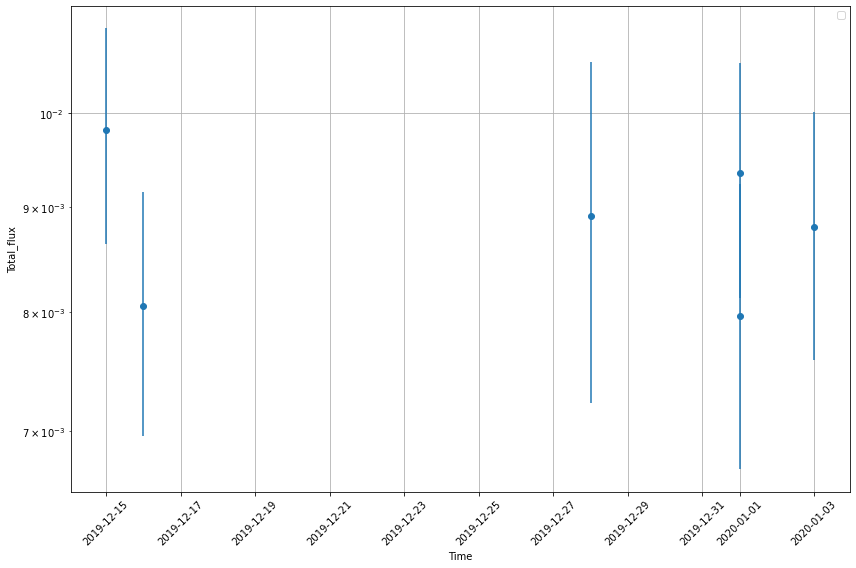

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


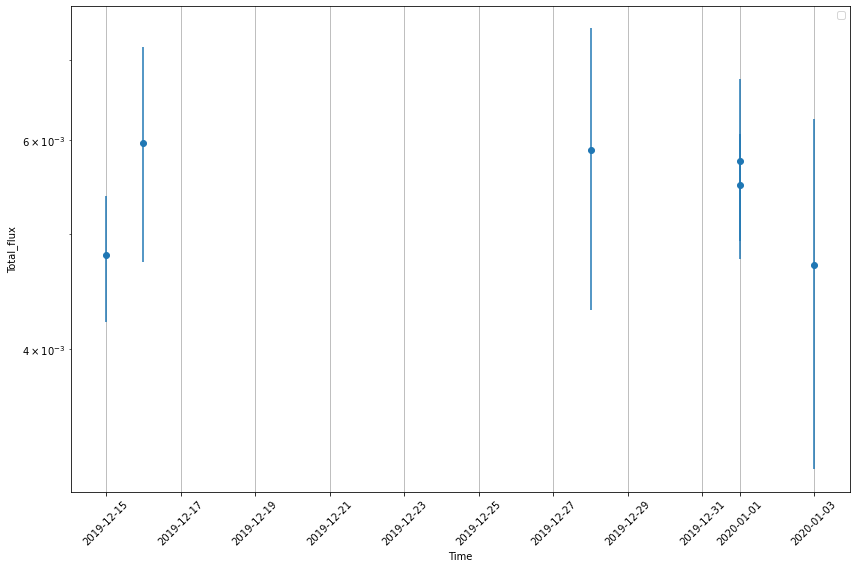

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


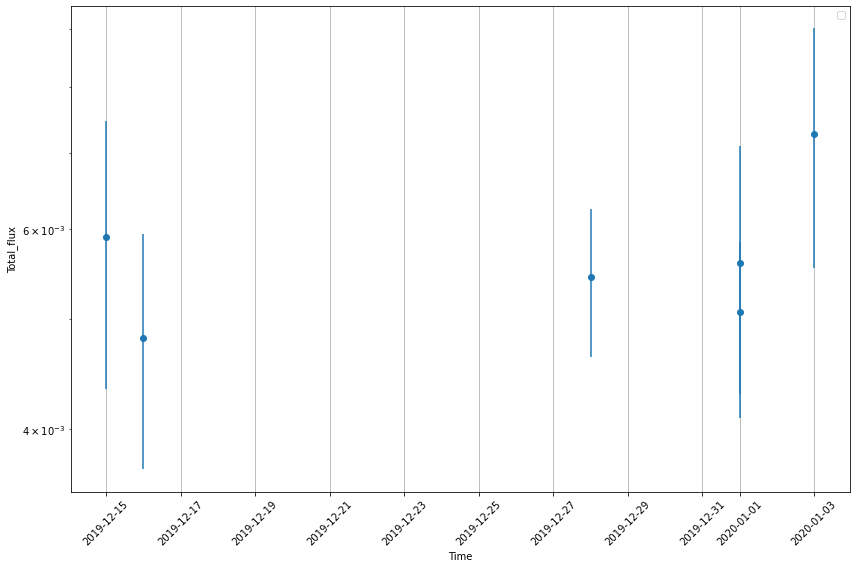

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


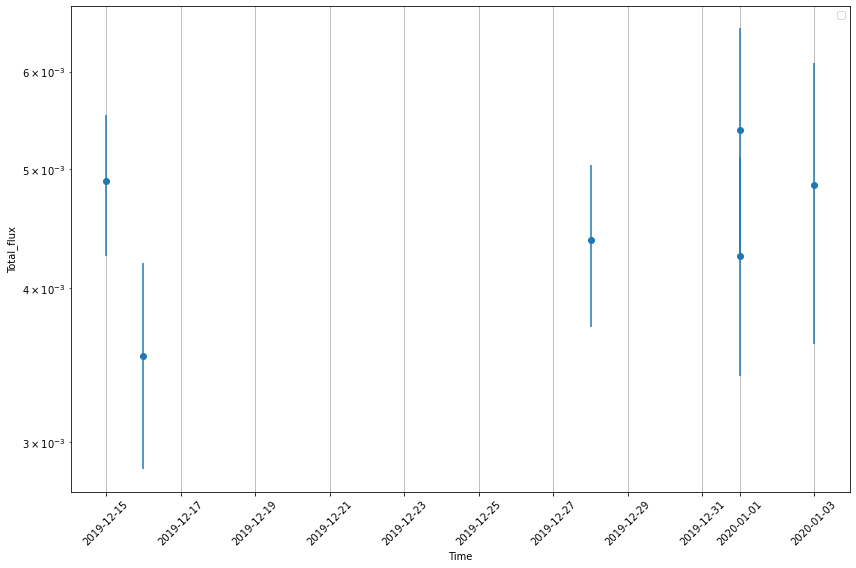

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


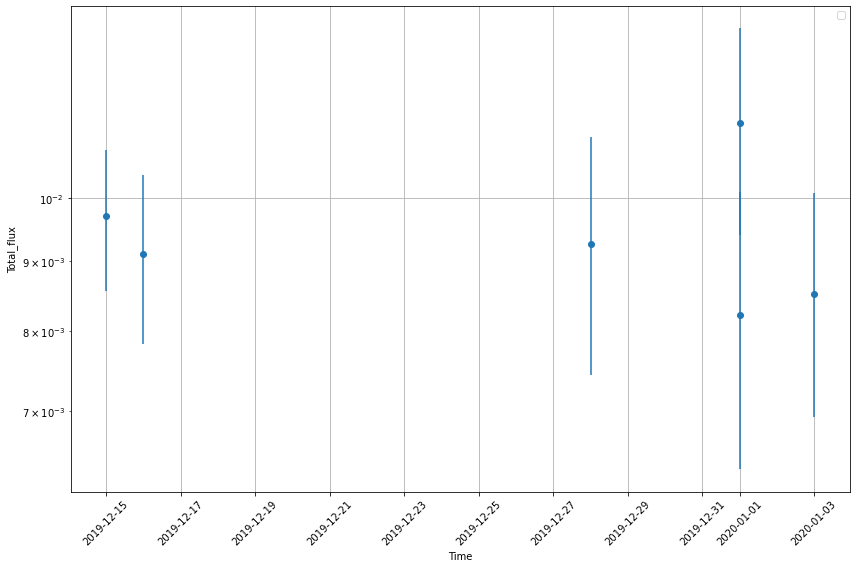

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


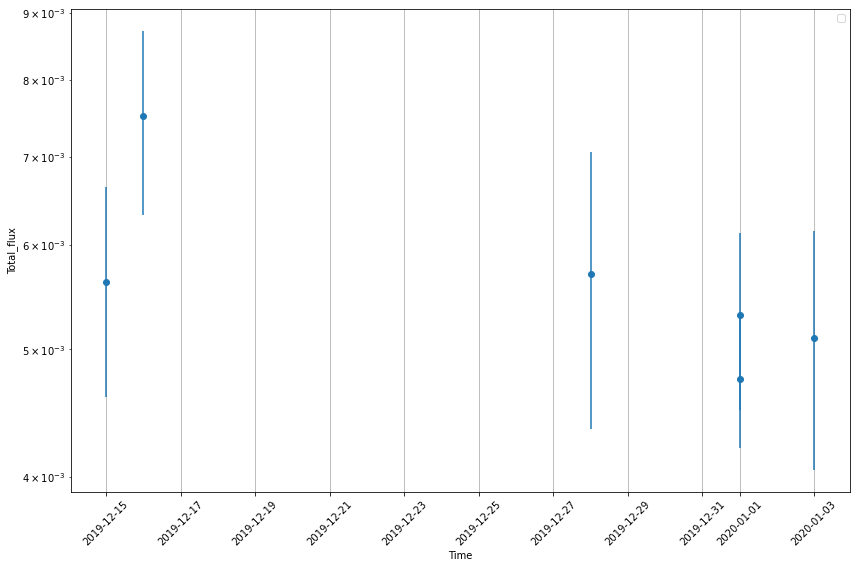

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


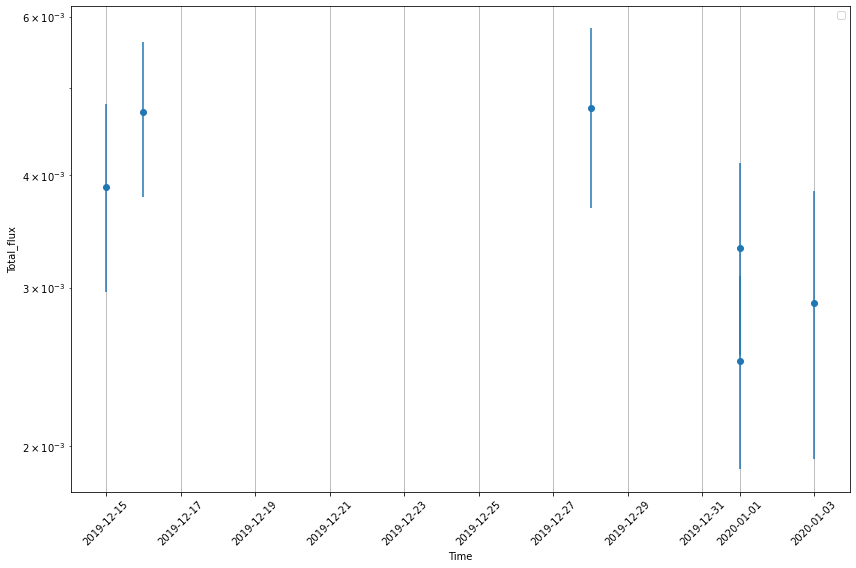

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


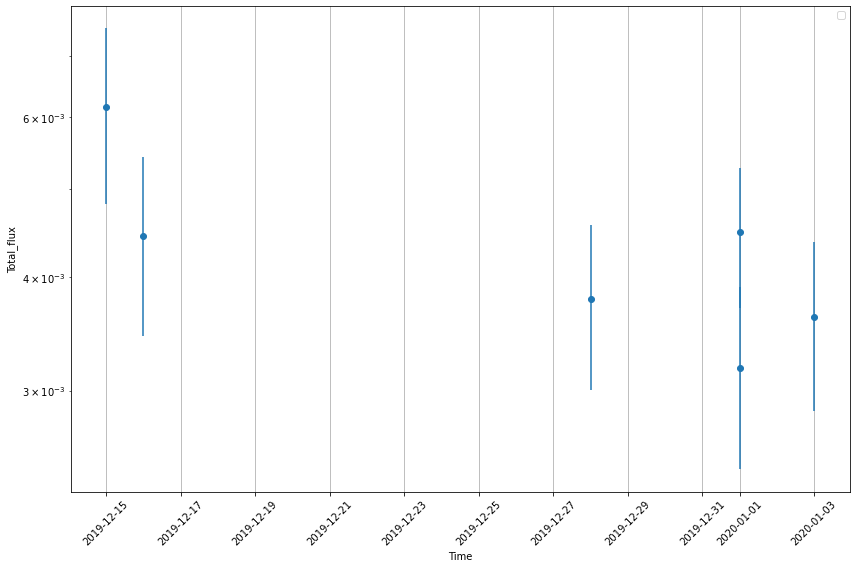

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


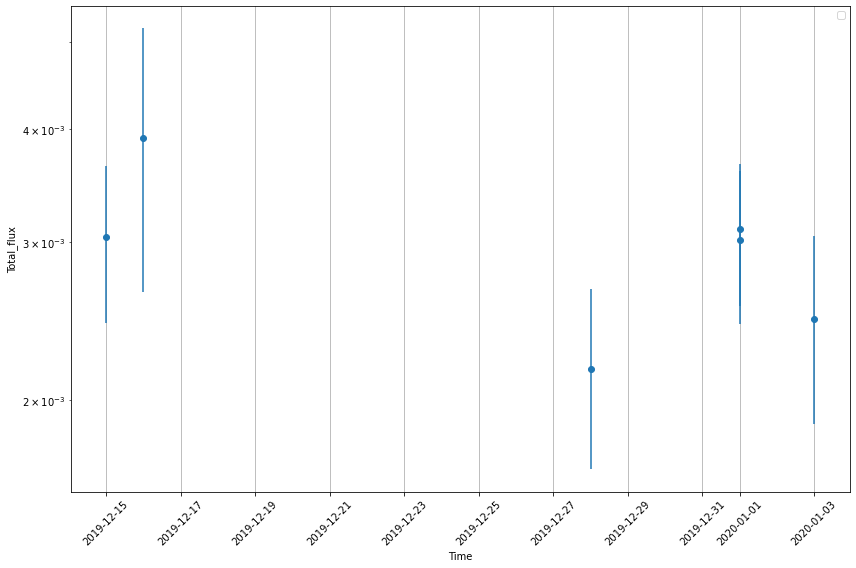

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


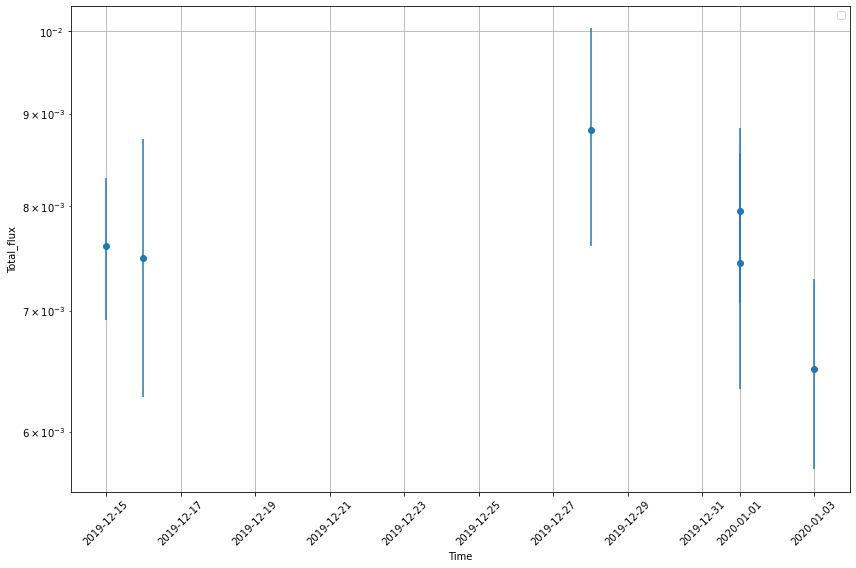

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


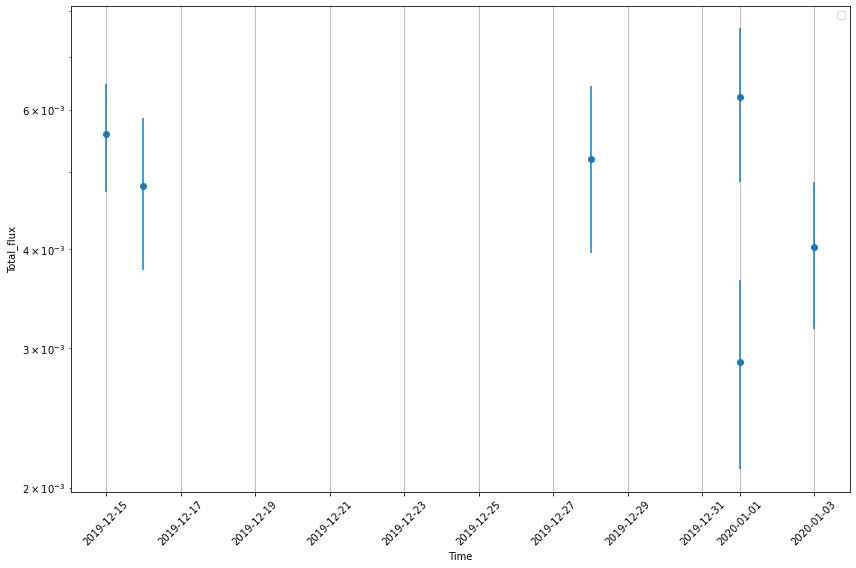

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


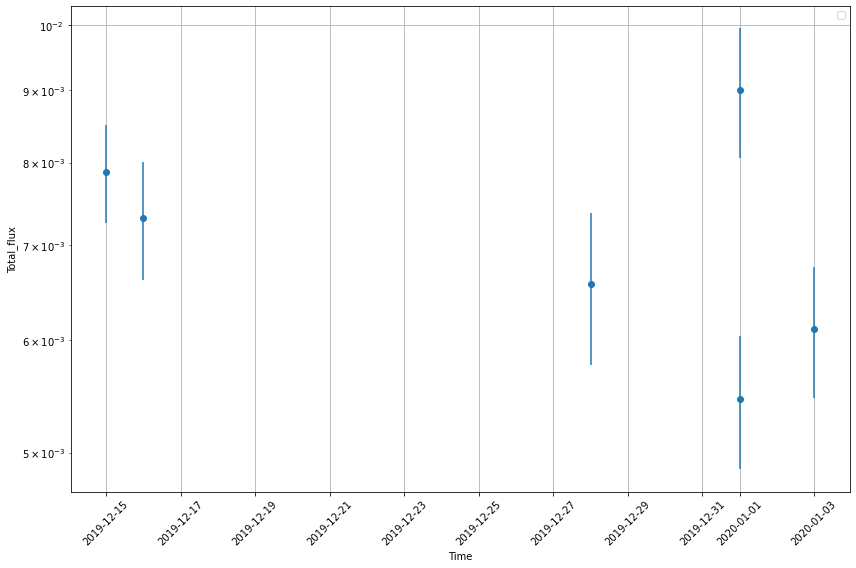

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


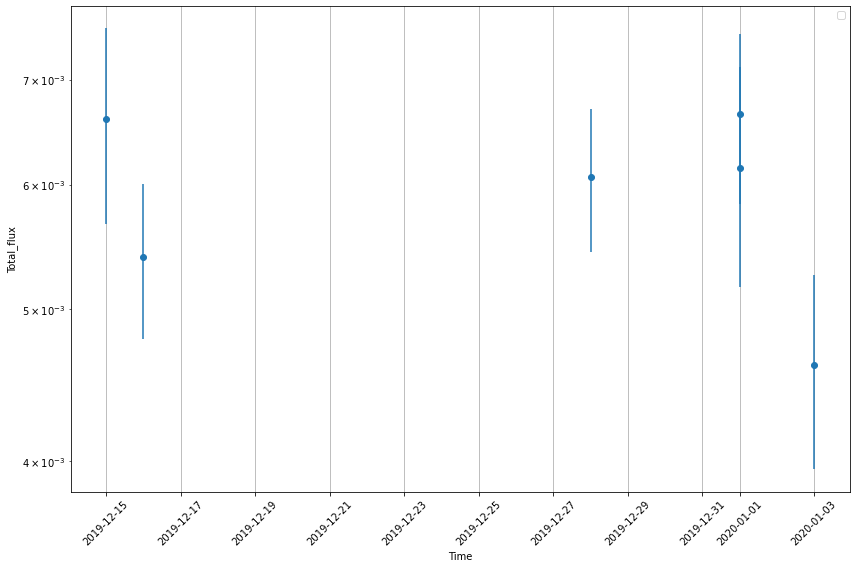

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


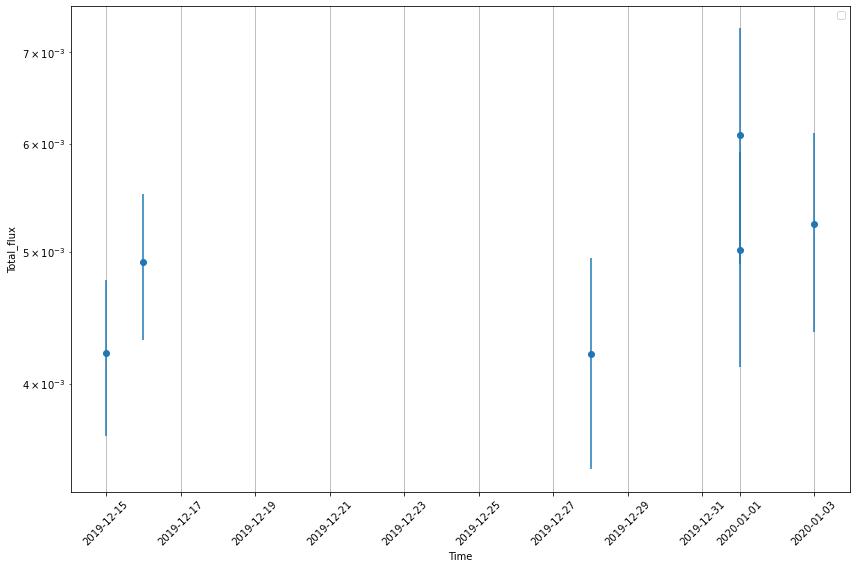

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


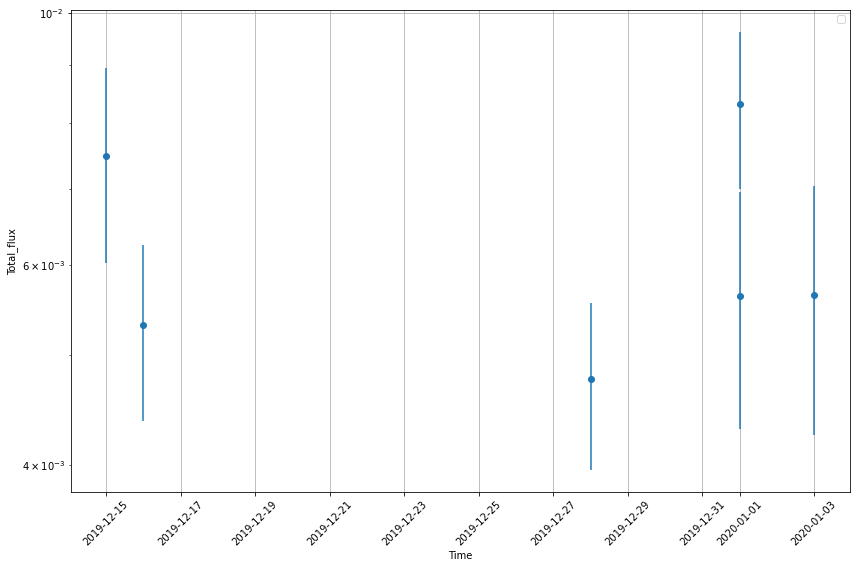

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


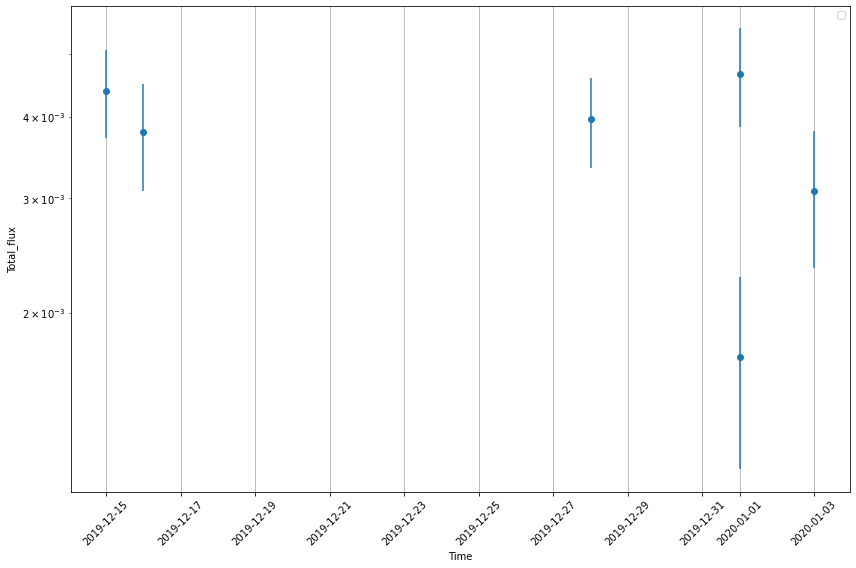

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


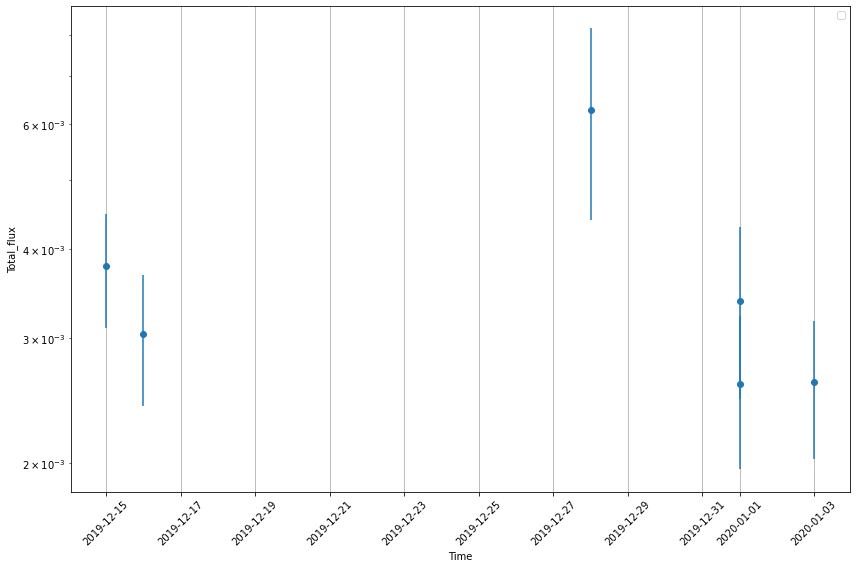

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


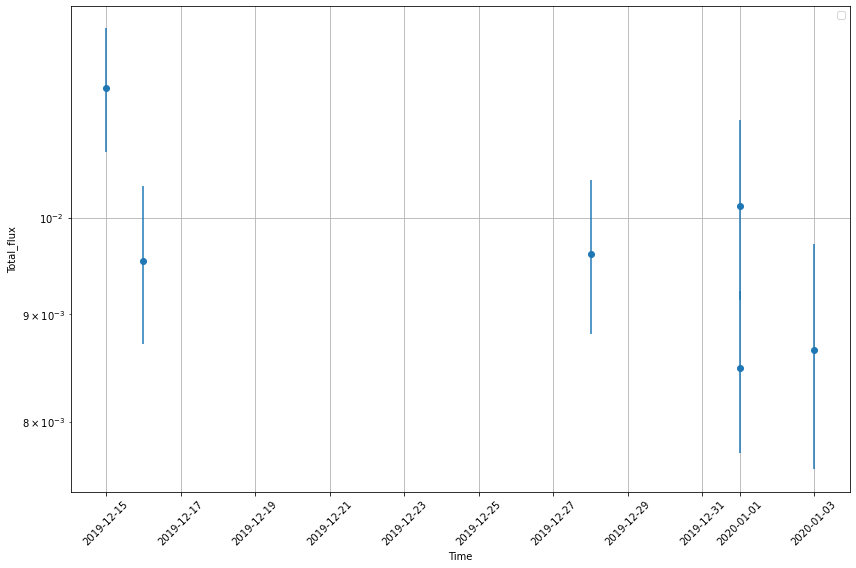

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


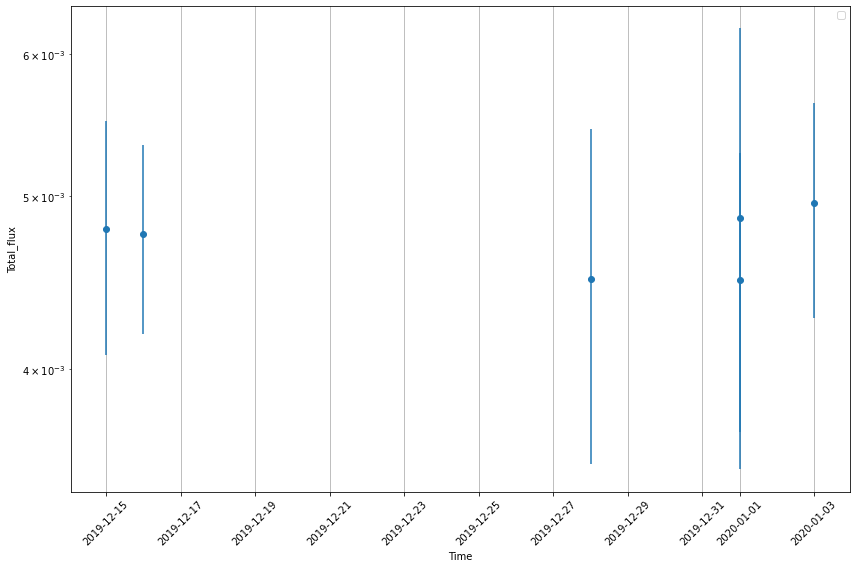

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


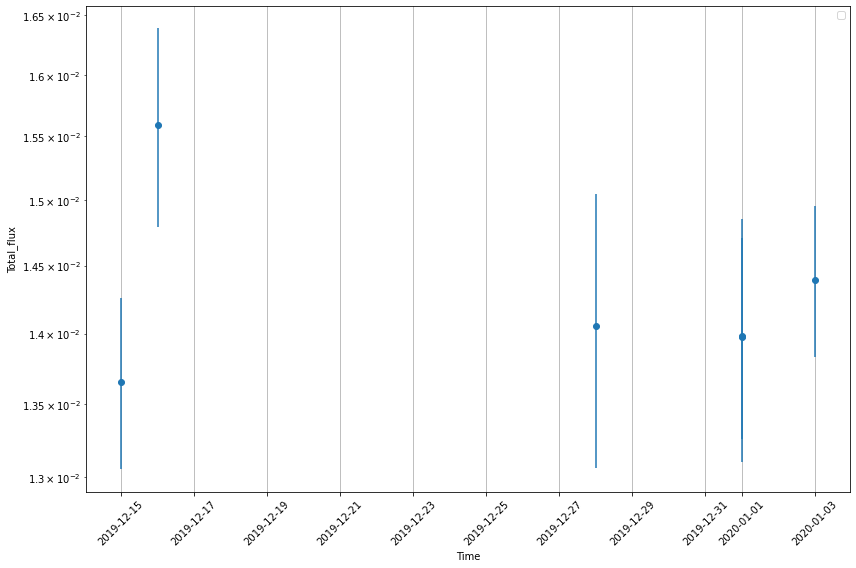

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


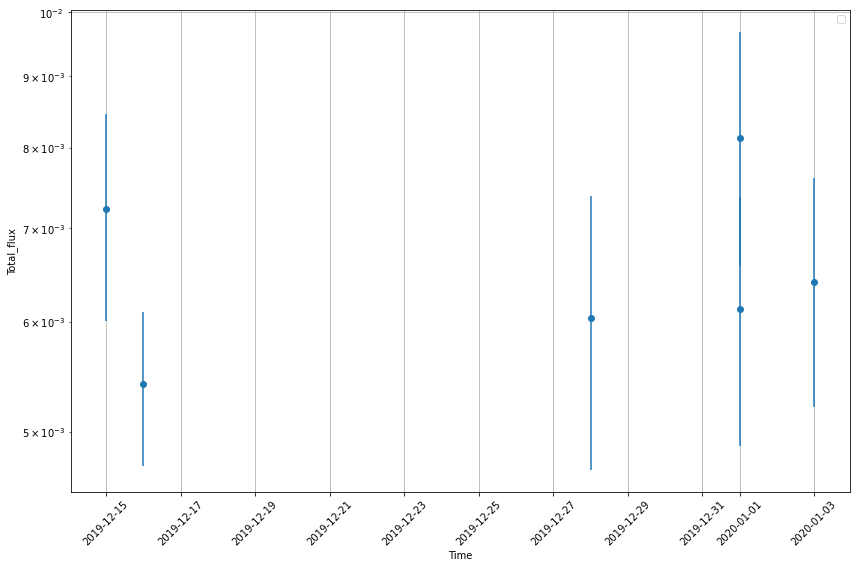

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


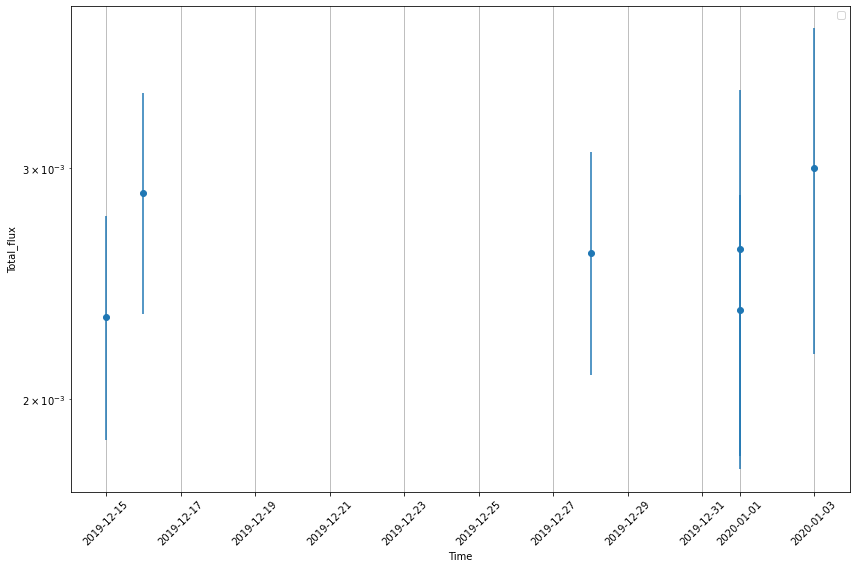

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


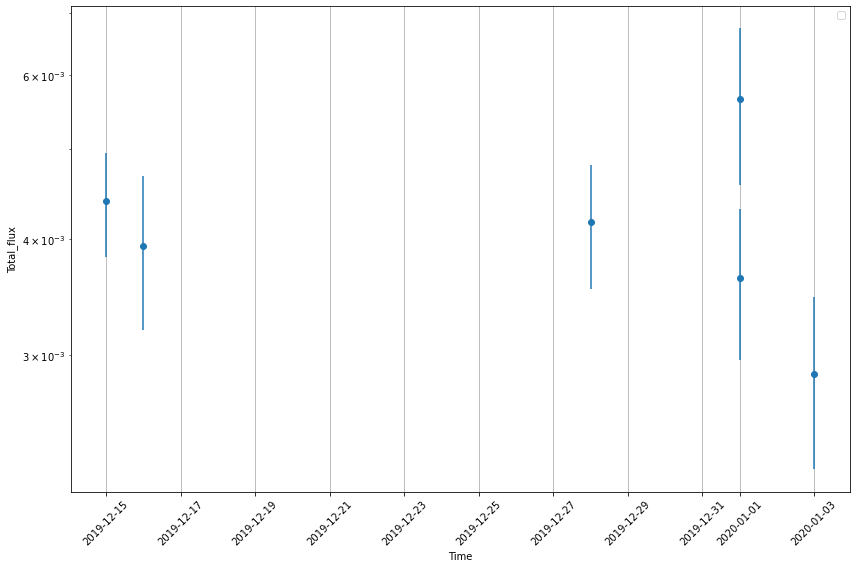

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


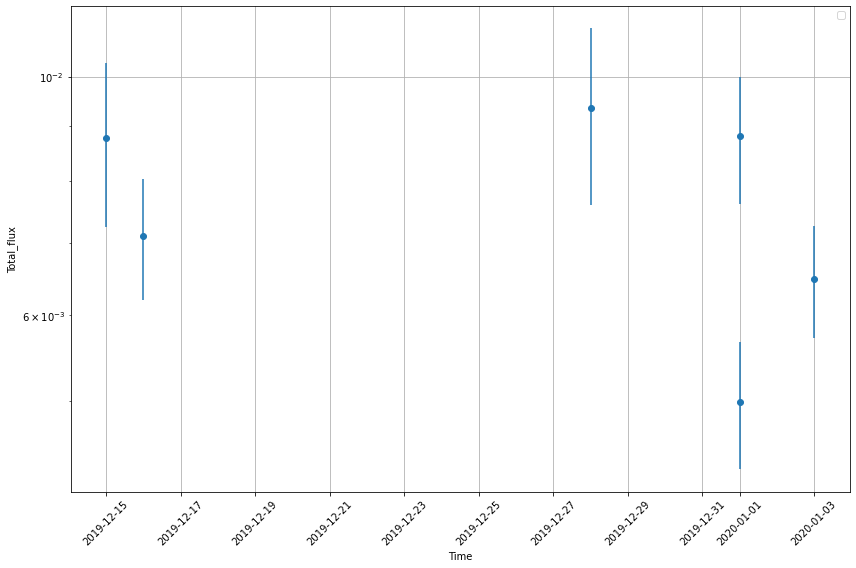

In [77]:

file_path = '../paper1/epoch/32/processed/repeated_sources_with_times.csv'
df = pd.read_csv(file_path)

# Ensure 'Times', 'Total_flux', and 'E_Total_flux' are lists of values
df['Times'] = df['Times'].apply(lambda x: x.strip('[]').replace("'", "").split(', '))
df['Total_flux'] = df['Total_flux'].apply(lambda x: list(map(float, x.strip('[]').split(', '))))
df['E_Total_flux'] = df['E_Total_flux'].apply(lambda x: list(map(float, x.strip('[]').split(', '))))

# Plot 'Total_flux' with 'E_Total_flux' as error bars for each source over time
for index, source in df.iterrows():
    times = pd.to_datetime(source['Times'], format='%Y_%m_%d')
    total_flux = source['Total_flux']
    e_total_flux = source['E_Total_flux']
    
    plt.figure(figsize=(12, 8))  # Increase figure size
    plt.errorbar(times, total_flux, yerr=e_total_flux, fmt='o')
    plt.xlabel('Time')
    plt.ylabel('Total_flux')
    plt.yscale('log')  # Set y-axis to log scale
    # plt.title(f'Total_flux over Time with Error Bars for Source RA: {source["RA"]}, DEC: {source["DEC"]}')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
